---
# Polymer Chain Monte Carlo Simulation - Lab Assignment
---
# Student Name: ___________________
# Date: ___________________

## Learning Objectives

By completing this lab, students will:
1. Understand and implement **Lennard-Jones** and **FENE** potentials.
2. Recognize **numerical issues** in potential energy calculations.
3. Apply the **Metropolis Monte Carlo (MC)** algorithm for molecular simulations.
4. Analyze **polymer chain structural properties** from simulation data.

---

Polymers are large molecules composed of many repeated units, called **monomers**, linked end to end.  

There are two main types of polymers:  
- **Naturally occurring polymers**, such as *cellulose*.  
- **Artificial polymers**, such as *polythene* (polyethylene).  

A simple model of a polymer assumes that each linked unit is oriented **completely randomly** relative to the others. This leads to an almost **infinite number of possible configurations** for the polymer chain.  

As a result, a polymer chain typically appears as a **randomly tangled mess**!

## Pre-Lab Preparation

### Student Preparation 
Students should review:
1. **Thermodynamics:** Boltzmann distribution P(E) ∝ exp(-E/kT)
2. **Python:** NumPy array operations, loops, basic plotting
3. **Chemistry:** Van der Waals forces, covalent bonding concepts

### Materials Needed
- Jupyter notebook environment (JupyterLab, Google Colab, or similar)
- Python packages: `numpy`, `plotly`, `ase`
- Installation commands:
  ```bash
  pip install numpy plotly ase
  ```





---

##  The Metropolis Monte Carlo Algorithm

The **Metropolis Monte Carlo** (MC) method is a stochastic algorithm used to sample configurations of a system according to the **Boltzmann distribution**.  
It is particularly useful for systems where direct integration of phase space is infeasible.

###  Algorithm Overview

We seek to generate configurations $ \{ \mathbf{r}_i \} $ with a probability proportional to:

$$
P(\mathbf{r}_1, \dots, \mathbf{r}_N) \propto e^{-\beta U(\mathbf{r}_1, \dots, \mathbf{r}_N)}
$$
where  
- $ \beta = 1 / (k_B T) $ is the inverse thermal energy,  
- $ U $ is the potential energy of the configuration.

###  Metropolis Steps

1. **Initialization**  
   Start from an initial configuration $ \mathbf{r}^{(0)} $ and compute its energy $ U^{(0)} $.

2. **Trial Move**  
   Propose a new configuration $ \mathbf{r}' $ by slightly perturbing one or more particle positions.

3. **Energy Evaluation**  
   Compute the new potential energy $ U' $.

4. **Acceptance Criterion**  
   The trial move is accepted with probability:

   $$
   P_{\text{acc}} = \min \left[ 1, \exp(-\beta (U' - U)) \right]
   $$

   - If $ U' < U $, the move is always accepted.  
   - If $ U' > U $, it may still be accepted with a Boltzmann-weighted probability.

5. **Update**  
   - If accepted, set $ \mathbf{r}^{(t+1)} = \mathbf{r}' $.  
   - Otherwise, keep the old configuration $ \mathbf{r}^{(t+1)} = \mathbf{r}^{(t)} $.

6. **Iteration**  
   Repeat the process for many Monte Carlo steps to sample the equilibrium ensemble.

---

###  Pseudocode

```python
initialize_positions()
compute U_old = potential_energy(positions)

for step in range(N_steps):
    trial_positions = propose_move(positions)
    U_new = potential_energy(trial_positions)
    dU = U_new - U_old

    if random() < exp(-beta * dU):
        positions = trial_positions
        U_old = U_new

In [1]:

import numpy as np
import plotly.graph_objects as go
from ase import Atoms
from ase.io import write

print("="*80)
print("POLYMER CHAIN MONTE CARLO SIMULATION LAB")
print("="*80)

POLYMER CHAIN MONTE CARLO SIMULATION LAB


In [2]:
# ==============================================================================
# PART 0: INTRODUCTION TO THE PROBLEM
# ==============================================================================

"""
PROBLEM OVERVIEW:
=================
In this lab, you will simulate a polymer chain consisting of N beads connected
by springs. The system is governed by two types of interactions:

1. BONDED INTERACTIONS (FENE potential):
   - Acts between consecutive beads along the chain
   - Models the connectivity of the polymer backbone
   - Prevents bonds from stretching beyond physical limits

2. NON-BONDED INTERACTIONS (Lennard-Jones potential):
   - Acts between all non-bonded bead pairs
   - Models van der Waals forces (attraction + repulsion)
   - Prevents beads from overlapping

SIMULATION METHOD:
==================
We use the Metropolis Monte Carlo (MC) algorithm:
- Generate random trial moves of the chain
- Accept/reject based on energy change and temperature
- This samples the Boltzmann distribution without solving equations of motion
"""

# ==============================================================================
# PART 1: SIMULATION PARAMETERS
# ==============================================================================

"""
PARAMETER SETUP:
================
Before we begin, we need to define the system parameters.
These control the chain properties and simulation behavior.
"""

N = 50                 # Number of beads in the polymer chain
r0 = 0.7              # Equilibrium bond length (Angstroms)
max_delta = 0.01       # Maximum displacement per MC move (Angstroms)
T = 1.0                # Temperature in reduced units (kB*T)
n_steps = 50_000       # Total number of Monte Carlo steps

# FENE (bonded) parameters
K = 40.0               # Spring constant (energy units)
R = 0.3                # Maximum bond extensibility beyond r0

# Lennard-Jones (non-bonded) parameters
epsilon = 1.0          # LJ well depth (energy units)
sigma = 1.0           # LJ characteristic length (Angstroms)
rcutoff = 1.12246152962189  # Cutoff distance for LJ interactions

print(f"\n{'SIMULATION PARAMETERS':^80}")
print("="*80)
print(f"Chain parameters: N={N}, r0={r0}, max_delta={max_delta}")
print(f"MC parameters: T={T}, n_steps={n_steps}")
print(f"FENE: K={K}, R={R}, allowed bond range=[{r0-R:.3f}, {r0+R:.3f}]")
print(f"LJ: epsilon={epsilon}, sigma={sigma}, cutoff={rcutoff:.3f}")
print("="*80)


                             SIMULATION PARAMETERS                              
Chain parameters: N=50, r0=0.7, max_delta=0.01
MC parameters: T=1.0, n_steps=50000
FENE: K=40.0, R=0.3, allowed bond range=[0.400, 1.000]
LJ: epsilon=1.0, sigma=1.0, cutoff=1.122


**Questions:**
- *Why N=50?* Large enough to show polymer behavior, small enough to run quickly
- *What are reduced units?* Energy in units of ε, distance in units of σ


In [ ]:
# We use 50 monomers so that we can show the behavior of a small polymer chain

# The reduced units is a way to reduce the amount of computations needed. By simplifying to standard scale constants we do not need to waste computations
# on being exact in "Nano" scales
# It is also used to be able to cross reference from 1 system to another

<details>
<summary><b>Click for the Answers</b></summary>

- **Coarse-Grained Representation:**  
  In molecular simulations, a **coarse-grained (CG)** model simplifies the system by grouping several atoms into a single interaction site or "bead."  
  Each bead represents an effective unit of the polymer chain (e.g., a monomer segment).  
  This reduces computational cost while preserving essential structural and thermodynamic behavior.

- **Reduced (Dimensionless) Units:**  
  To generalize results and eliminate dependence on specific materials, simulations are often carried out in **reduced units**, based on the characteristic scales of the **Lennard–Jones (LJ)** potential:
  $$
  \sigma = \text{characteristic length (particle diameter)}, \quad 
  \varepsilon = \text{characteristic energy scale}, \quad 
  m = \text{particle mass}.
  $$
  In reduced form:
  $$
  r^* = \frac{r}{\sigma}, \quad 
  U^* = \frac{U}{\varepsilon}, \quad 
  T^* = \frac{k_B T}{\varepsilon}.
  $$
  This normalization allows the results to apply to any system with similar interaction ratios, not just one material.

- **Monte Carlo Steps and Time:**  
  Monte Carlo (MC) simulations do **not** evolve the system in real time.  
  Each **MC step** corresponds to an *attempted configuration change* (e.g., moving one bead).  
  Thus, MC trajectories represent **sampling of equilibrium configurations**, not physical dynamics.  
  The focus is on reaching **statistical equilibrium** rather than integrating motion equations.

---

#### Questions & Answers

- **Why choose $ N = 50 $?**  
  A polymer with 50 beads is long enough to exhibit **characteristic polymer behavior** (entropic coiling, excluded volume, etc.) while remaining computationally manageable for classroom or lab simulations.

- **What are reduced units and why use them?**  
  Reduced units nondimensionalize the equations, improving numerical stability and making simulations **system-independent**.  
  For example:
  - Energy is measured in units of $ \varepsilon $
  - Distance is measured in units of $ \sigma $
  - Temperature in units of $ \varepsilon / k_B $

  This scaling simplifies comparison between different systems and potential functions.

- **Does one MC step correspond to a real time interval?**  
  No — MC steps correspond to **sampling attempts**, not physical time.  
  The algorithm is designed to produce configurations distributed according to the **Boltzmann probability**, not to reproduce trajectories as in molecular dynamics.

</details>

### Part 2: Lennard-Jones Potential

####  Key Concepts

The **Lennard-Jones (LJ)** potential describes the interaction between two neutral particles as a balance between:

- **Attractive term ( − r⁻⁶ )** — arising from **induced dipole–dipole (van der Waals)** interactions  
- **Repulsive term ( + r⁻¹² )** — approximating **Pauli exclusion** due to overlapping electron clouds

The potential energy between two particles separated by a distance $ r $ is:

$$
U_{\mathrm{LJ}}(r)
= 4\varepsilon \left[ \left(\frac{\sigma}{r}\right)^{12}
- \left(\frac{\sigma}{r}\right)^6 \right]
$$

where  
- $ \varepsilon $: depth of the potential well (interaction strength)  
- $ \sigma $: finite distance where $ U_{\mathrm{LJ}} = 0 $ (effective particle diameter)

####  Characteristic Features

- The **potential minimum** occurs at  
  $$
  r_{\min} = 2^{1/6}\,\sigma \approx 1.122\,\sigma
  $$
  where $ U_{\mathrm{LJ}}(r_{\min}) = -\varepsilon $.
- For $ r < \sigma $, strong repulsion dominates.  
- For $ r > r_{\min} $, weak attraction dominates until it vanishes at large $ r $.
- A **cutoff distance** $ r_c $ (typically ≈ 2.5 σ) is used to ignore negligible interactions and save computation.



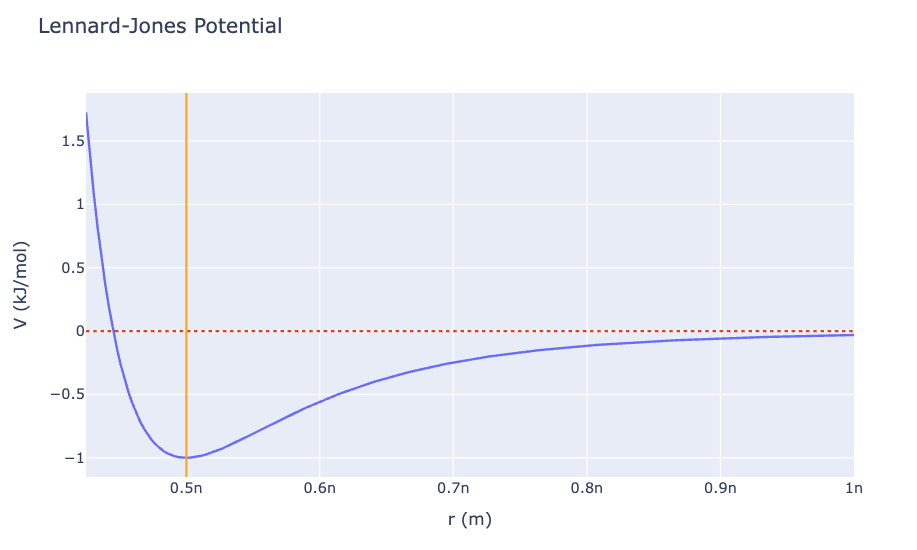

In [ ]:
# ==============================================================================
# PART 2: LENNARD-JONES POTENTIAL
# ==============================================================================

"""
THEORY: LENNARD-JONES POTENTIAL
================================
The Lennard-Jones (LJ) potential describes non-bonded interactions between
neutral atoms or molecules. It consists of:

1. ATTRACTIVE TERM (~ r^-6): Van der Waals attraction at medium distances
2. REPULSIVE TERM (~ r^-12): Strong repulsion at short distances (Pauli exclusion)

Mathematical Form:
------------------
    V_LJ(r) = 4ε[(σ/r)^12 - (σ/r)^6]

Where:
- r = distance between two beads
- ε (epsilon) = depth of the potential well (how strong the attraction is)
- σ (sigma) = distance at which V_LJ = 0 (characteristic size of bead)

Key Features:
-------------
- Minimum at r ≈ 2^(1/6)σ ≈ 1.12σ (equilibrium distance)
- V_LJ → 0 as r → ∞ (no interaction at large distances)
- V_LJ → +∞ as r → 0 (beads cannot overlap)

Cutoff:
-------
To save computation, we set V_LJ = 0 for r > r_cutoff (typically 2.5σ).
This is valid because LJ decays rapidly with distance.

YOUR TASK:
----------
Complete the function below to calculate the LJ potential energy.
"""

def lj(r2, epsilon=epsilon, sigma=sigma, r_cut=rcutoff):
    """
    Calculate Lennard-Jones potential energy.
    
    Parameters:
    -----------
    r2 : float
        SQUARED distance between two beads (r²)
        NOTE: We pass r² instead of r to avoid computing sqrt unnecessarily
    epsilon : float
        LJ well depth
    sigma : float
        LJ characteristic length
    r_cut : float
        Cutoff distance (no interaction beyond this)
    
    Returns:
    --------
    float : LJ potential energy
    
    HINT: The formula is V_LJ = 4ε[(σ/r)^12 - (σ/r)^6]
          To work with r² efficiently, note that:
          - (σ/r)² = σ²/r²
          - (σ/r)^6 = [(σ/r)²]³
          - (σ/r)^12 = [(σ/r)^6]²
    """

    # Early return if we are too far away (Larger than cutoff distance)
    if r2 > r_cut**2:
        return 0.0

    # Calculate the LJ Potential Factors
    sr2 = sigma**2 / r2
    sr6 = sr2**3

    # Calculate the LJ Potential Energy 
    V_LJ = 4*epsilon*(sr6**2 - sr6)

    return V_LJ

In [120]:
# Test your LJ function
print("\n" + "="*80)
print("TESTING LENNARD-JONES POTENTIAL")
print("="*80)
test_distances = np.array([0.5, 0.56, 0.7, 1.0, 2.0, 3.0])
for r in test_distances:
    r_squared = r**2
    energy = lj(r_squared)
    print(f"r = {r:.2f} Å → V_LJ = {energy:+.4f} (energy units)")


TESTING LENNARD-JONES POTENTIAL
r = 0.50 Å → V_LJ = +16128.0000 (energy units)
r = 0.56 Å → V_LJ = +4075.6672 (energy units)
r = 0.70 Å → V_LJ = +254.9910 (energy units)
r = 1.00 Å → V_LJ = +0.0000 (energy units)
r = 2.00 Å → V_LJ = +0.0000 (energy units)
r = 3.00 Å → V_LJ = +0.0000 (energy units)


In [121]:
import numpy as np
import plotly.graph_objects as go

# --- Parameters for LJ ---
rmin = 0.5e-9   # 0.5 nm = 5 Å
rmax = 1.0e-9   # 1 nm = 10 Å
epsilon = 1.0   # kJ/mol
sigma = rmin / 2**(1/6)

# r grid
rs = np.linspace(rmin - 0.75e-10, rmax, 200)

# LJ potential
vs = 4 * epsilon * ((sigma/rs)**12 - (sigma/rs)**6)

# --- Plot with Plotly ---
fig = go.Figure()

fig.add_trace(go.Scatter(x=rs, y=vs, mode="lines", name="LJ Potential"))

# Horizontal line at zero
fig.add_hline(y=0, line=dict(color="red", dash="dot"))

# Vertical line at minimum
fig.add_vline(x=rs[vs.argmin()], line=dict(color="orange"))

fig.update_layout(
    title="Lennard-Jones Potential",
    xaxis_title="r (m)",
    yaxis_title="V (kJ/mol)",
    width=800,
    height=500
)

fig.show()



###  Part 3: FENE Potential

####  Key Concept

The **FENE (Finite Extensible Nonlinear Elastic)** potential models **bonded interactions** between adjacent polymer beads.  
Unlike a harmonic spring, it prevents unphysical bond stretching by diverging as the bond length approaches a **maximum extension** $ R_0 $.

It is widely used in the **Kremer–Grest bead-spring polymer model**.

---

####  Mathematical Form (Kremer–Grest Form)

$$
U_{\mathrm{FENE}}(r) =
\begin{cases}
-\dfrac{1}{2} k R_0^2 \ln\!\left[ 1 - \left( \dfrac{r}{R_0} \right)^2 \right],
& r < R_0, \\
\infty, & r \ge R_0
\end{cases}
$$

where  
- $ k $: spring constant (bond stiffness)  
- $ R_0 $: maximum bond extension  
- $ r $: instantaneous bond length between connected beads  

Typical polymer simulation parameters:  
$ k = 30 \, \varepsilon / \sigma^2 $, $ R_0 = 1.5 \, \sigma $

---

####  Alternative Form (with Equilibrium Bond Length $ r_{\mathrm{eq}} $)

A shifted form introduces an equilibrium bond length $ r_{\mathrm{eq}} $ (useful for asymmetric potentials):

$$
U_{\mathrm{FENE,alt}}(r) =
\begin{cases}
-\dfrac{1}{2} k (R_{\max} - r_{\mathrm{eq}})^2
\ln\!\left[ 1 - \left( \dfrac{r - r_{\mathrm{eq}}}{R_{\max} - r_{\mathrm{eq}}} \right)^2 \right],
& r_{\mathrm{eq}} - (R_{\max} - r_{\mathrm{eq}}) < r < R_{\max}, \\
\infty, & \text{otherwise.}
\end{cases}
$$

This form ensures that the potential minimum occurs near $ r = r_{\mathrm{eq}} $.

---

####  Qualitative Behavior

- The potential is **steeply confining** as $ r \to R_0 $.  
- Near equilibrium, it behaves approximately like a **harmonic spring**:
  $$
  U_{\mathrm{FENE}}(r) \approx \tfrac{1}{2} k r^2 \quad (r \ll R_0)
  $$
- Beyond $ R_0 $, the potential diverges → **bond cannot break**.  
- Often combined with the **Lennard–Jones** potential to prevent bead overlap and define the bond equilibrium distance.

---

####  Visualization (Example)

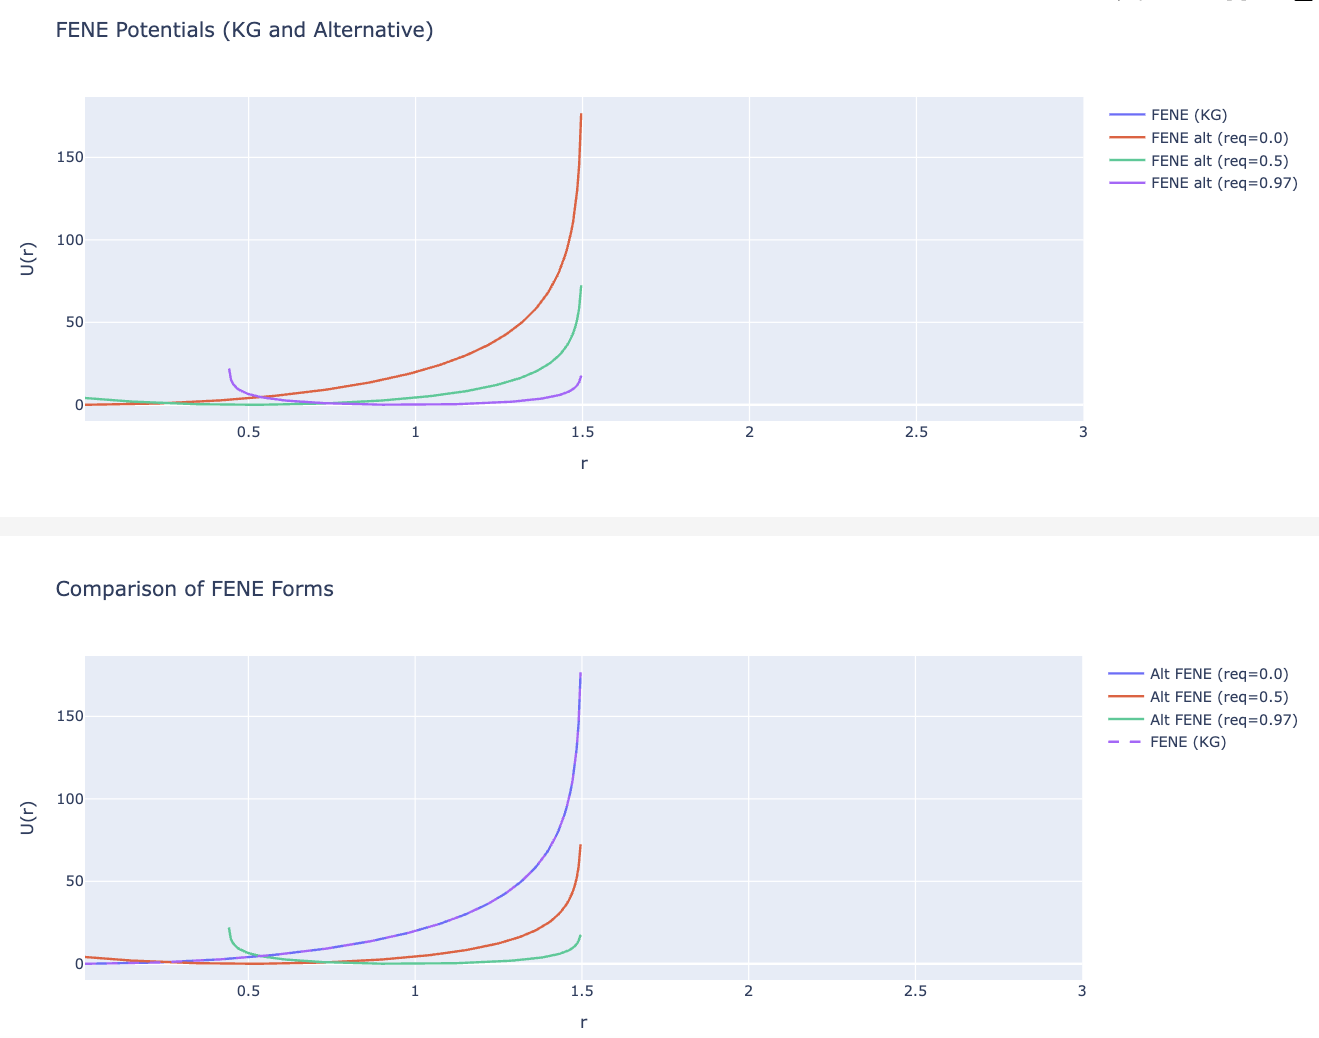

In [ ]:
# ==============================================================================
# PART 3: FENE POTENTIAL
# ==============================================================================

"""
THEORY: FENE POTENTIAL (FINITELY EXTENSIBLE NONLINEAR ELASTIC)
===============================================================
The FENE potential models bonds in polymer chains. Unlike a harmonic spring
(Hooke's law), FENE prevents bonds from extending indefinitely.

Mathematical Form (Modified):
-----------------------------
    V_FENE(r) = -½ K R² ln[1 - ((r - r₀)/R)²]

Where:
- r = bond length (distance between consecutive beads)
- r₀ = equilibrium bond length
- K = spring constant (stiffness)
- R = maximum extension beyond/below r₀

Valid Range:
------------
The bond length must satisfy: r₀ - R < r < r₀ + R
Outside this range, the potential → ∞ (bond breaks/overlaps)

CRITICAL NUMERICAL ISSUE:
==========================
The logarithm argument must be POSITIVE:

    1 - ((r - r₀)/R)² > 0
    
If this becomes ≤ 0, we get:
- log(0) = -∞ → numerical error
- log(negative) = NaN → simulation crashes

Physical Interpretation:
------------------------
- Near r₀: V_FENE ≈ ½K(r - r₀)² (harmonic spring)
- As r → r₀ ± R: V_FENE → +∞ (infinite force prevents further extension)

YOUR TASK:
----------
Complete the function below, paying special attention to the domain check!
"""

def fene(r2, K=K, R=R, r0=r0):
    """
    Calculate FENE (Finitely Extensible Nonlinear Elastic) potential energy.
    
    Parameters:
    -----------
    r2 : float
        SQUARED bond length (r²)
    K : float
        Spring constant
    R : float
        Maximum extensibility parameter
    r0 : float
        Equilibrium bond length
    
    Returns:
    --------
    float : FENE potential energy (returns np.inf if bond is out of range)
    
    FORMULA: V_FENE = -½ K R² ln[1 - ((r - r₀)/R)²]
    
    IMPORTANT: You must check that |r - r₀| < R before computing the log!
    """
    
    # TODO: Calculate actual distance r from r²
    # HINT: r = √(r²)
   Write your Code here
    
    # TODO: Check if bond is within valid range
    # The argument (r - r₀)/R must satisfy: |(r - r₀)/R| < 1
    # If not, return np.inf (infinite energy = bond broken)
   Write your Code here
    
    # TODO: Calculate the logarithm argument
    # HINT: arg = 1 - [(r - r₀)/R]²
   Write your Code here
    
    # TODO: Safety check - if arg ≤ 0, return infinity
    # This prevents log(negative) or log(0) errors
    Write your Code here
    
    # TODO: Calculate and return FENE energy
    # HINT: V_FENE = -½ K R² ln(arg)
    return Write your Code here





In [123]:
# Test your FENE function
print("\n" + "="*80)
print("TESTING FENE POTENTIAL")
print("="*80)
test_bond_lengths = np.array([0.4, 0.6, 0.7, 0.8, 0.95, 1.05])
for r in test_bond_lengths:
    r_squared = r**2
    energy = fene(r_squared)
    in_range = (r0 - R) < r < (r0 + R)
    print(f"r = {r:.2f} Å → V_FENE = {energy:+.4f} | In range: {in_range}")


TESTING FENE POTENTIAL
r = 0.40 Å → V_FENE = +63.6309 | In range: True
r = 0.60 Å → V_FENE = +0.2120 | In range: True
r = 0.70 Å → V_FENE = -0.0000 | In range: True
r = 0.80 Å → V_FENE = +0.2120 | In range: True
r = 0.95 Å → V_FENE = +2.1341 | In range: True
r = 1.05 Å → V_FENE = +inf | In range: False


### Part 4: Chain Initialization

**Key Points:**
- Linear chain is NOT equilibrium (high energy)
- This tests if simulation can find lower energy states
- Real experiments might start from different initial conditions

**Discussion:**
- What would happen starting from a random configuration?
- What about starting from a collapsed globule?


In [ ]:
# ==============================================================================
# PART 4: CHAIN INITIALIZATION
# ==============================================================================

"""
CHAIN INITIALIZATION:
=====================
We start with a simple linear configuration: all beads arranged along the x-axis
with spacing equal to r₀ (equilibrium bond length).

This is not the equilibrium structure! The chain will fold and compact during
the MC simulation as it explores lower energy configurations.

YOUR TASK:
----------
Generate initial coordinates for N beads arranged linearly.
"""

def gen_chain(N, r0):
    """
    Generate initial linear polymer chain along x-axis.
    
    Parameters:
    -----------
    N : int
        Number of beads
    r0 : float
        Initial spacing between beads
    
    Returns:
    --------
    np.ndarray : Nx3 array of (x, y, z) coordinates
    
    HINT: Use np.linspace to create evenly spaced x-coordinates from 0 to (N-1)*r0
          Set y and z to zero using np.zeros
          Combine into Nx3 array using np.column_stack
    """
    
    # TODO: Create x-coordinates: [0, r0, 2*r0, ..., (N-1)*r0]
    Write your Code here
    
    # TODO: Create y and z coordinates (all zeros)
    Write your Code here
    Write your Code here
    
    # TODO: Combine into Nx3 array
    return Write your Code here


# Generate initial chain
coords = gen_chain(N, r0)
print("\n" + "="*80)
print("INITIAL CHAIN GENERATED")
print("="*80)
print(f"Chain shape: {coords.shape}")
print(f"First bead: {coords[0]}")
print(f"Last bead: {coords[-1]}")
print(f"Initial end-to-end distance: {np.linalg.norm(coords[-1] - coords[0]):.3f} Å")


INITIAL CHAIN GENERATED
Chain shape: (50, 3)
First bead: [0. 0. 0.]
Last bead: [34.3  0.   0. ]
Initial end-to-end distance: 34.300 Å


---

### Part 5: Total Energy

**Key Concepts:**
- **Non-bonded pairs:** All (i,j) where j > i+1
  - Skip j = i+1 because those are bonded pairs
- **Bonded pairs:** Only consecutive (i, i+1)
- Early return on np.inf (efficiency)



In [125]:
# ==============================================================================
# PART 5: TOTAL ENERGY CALCULATION
# ==============================================================================

"""
TOTAL ENERGY CALCULATION:
==========================
The total energy is the sum of:

1. NON-BONDED ENERGY (LJ):
   - Sum over all pairs (i,j) where j > i+1
   - We skip adjacent beads (j = i+1) because they're bonded
   
2. BONDED ENERGY (FENE):
   - Sum over all consecutive pairs (i, i+1)
   - These are the bonds connecting the chain

Mathematical Expression:
------------------------
    E_total = Σ(i<j, j≠i+1) V_LJ(r_ij) + Σ(i=1 to N-1) V_FENE(r_i,i+1)

YOUR TASK:
----------
Calculate the total energy by summing LJ and FENE contributions.
"""

def total_energy(coords):
    """
    Compute total potential energy of the polymer chain.
    
    Parameters:
    -----------
    coords : np.ndarray
        Nx3 array of bead coordinates
    
    Returns:
    --------
    float : Total energy (returns np.inf if any bond is broken)
    
    ALGORITHM:
    ----------
    1. Initialize e_nb (non-bonded energy) = 0
    2. Initialize e_bond (bonded energy) = 0
    3. Loop over all pairs (i,j) with j > i+1:
         - Calculate r_ij² = |coords[j] - coords[i]|²
         - Add V_LJ(r_ij²) to e_nb
    4. Loop over consecutive pairs (i, i+1):
         - Calculate r_i,i+1²
         - Add V_FENE(r_i,i+1²) to e_bond
         - If V_FENE = ∞, return ∞ immediately
    5. Return e_nb + e_bond
    """
    
    e_nb = 0.0      # Non-bonded (LJ) energy
    e_bond = 0.0    # Bonded (FENE) energy
    
    # TODO: Calculate non-bonded energy
    # Loop over all pairs (i,j) where j > i+1
    # HINT: Use nested loops - outer from i=0 to N-1, inner from j=i+2 to N
    for i in range(N):
        for j in range(i+2, N):  # Skip i+1 (bonded neighbor)
            # TODO: Calculate squared distance between bead i and j
            # HINT: rij2 = sum of squared differences in coordinates
            rij2 = np.sum((coords[j] - coords[i])**2)
            
            # TODO: Add LJ energy for this pair
            e_nb += lj(rij2)
    
    # TODO: Calculate bonded energy
    # Loop over consecutive pairs (i, i+1)
    # HINT: Loop from i=1 to N-1, bond connects i and i-1
    for i in range(1, N):
        # TODO: Calculate squared distance between consecutive beads
        rij2 = np.sum((coords[i] - coords[i-1])**2)
        
        # TODO: Add FENE energy for this bond
        bond_energy = fene(rij2)
        e_bond += bond_energy
        
        # TODO: If bond is broken (energy = infinity), return infinity immediately
        if np.isinf(e_bond):
            return np.inf
    
    # TODO: Return total energy
    return e_nb + e_bond


# Calculate initial energy
energy_current = total_energy(coords)
print("\n" + "="*80)
print("INITIAL ENERGY")
print("="*80)
print(f"Total energy: {energy_current:.4f} (energy units)")



INITIAL ENERGY
Total energy: 0.0000 (energy units)


### Part : MC Moves

**Key Points:**
- Displacement magnitude controlled by max_delta
- All atoms move simultaneously (simple scheme)
- More sophisticated: move one atom at a time

**Discussion:**
- What happens if max_delta is too large?
- What happens if max_delta is too small?
- How would you optimize max_delta automatically?

---

<details>
<summary><b>MC Moves —  Answers</b></summary>


- **If `max_delta` is too large:**  
  Most trial moves will be rejected because they cause big energy changes → **low acceptance ratio** and poor sampling efficiency.

- **If `max_delta` is too small:**  
  Almost all moves are accepted, but configurations change very slowly → **slow exploration** of phase space and poor ergodicity.

- **How to optimize `max_delta` automatically:**  
  Adjust `max_delta` adaptively to maintain an **acceptance ratio around 30–50 %**.  
  For example, increase `max_delta` if acceptance > 50 %, and decrease it if acceptance < 30 %.
  </details>

In [ ]:
# ==============================================================================
# PART 6: MONTE CARLO MOVES
# ==============================================================================

"""
MONTE CARLO TRIAL MOVES:
=========================
At each MC step, we generate a "trial" configuration by randomly displacing
all beads. The displacement is small and random.

Move Generation:
----------------
For each bead, we add a random displacement in x, y, z:
    
    x_new = x_old + δ * (random number between -1 and +1)
    
where δ = max_delta (maximum displacement parameter)

YOUR TASK:
----------
Generate a trial configuration by adding random displacements.
"""

def move(coords):
    """
    Generate trial configuration by random displacement.
    
    Parameters:
    -----------
    coords : np.ndarray
        Current Nx3 coordinates
    
    Returns:
    --------
    np.ndarray : Trial Nx3 coordinates
    
    ALGORITHM:
    ----------
    1. Copy current coordinates
    2. Generate random displacements in [-1, +1] for all coordinates
    3. Scale by max_delta
    4. Add to coordinates
    
    HINT: np.random.rand(*shape) gives random numbers in [0, 1]
          To get [-1, +1]: 2*np.random.rand(*shape) - 1
    """
    
    # TODO: Make a copy of current coordinates
    Write your Code here
    
    # TODO: Add random displacement
    # HINT: displacement = (2*random - 1) * max_delta
    Write your Code here
    
    return trial





print("\n" + "="*80)
print("MONTE CARLO MOVE FUNCTION READY")
print("="*80)



MONTE CARLO MOVE FUNCTION READY



### Part 7: Metropolis Criterion

**Key Concepts:**
1. **Downhill moves (ΔE < 0):** Always accept
   - System naturally seeks lower energy
   
2. **Uphill moves (ΔE > 0):** Accept probabilistically
   - Probability = exp(-ΔE/kT)
   - Allows escape from local minima
   - Temperature controls exploration

**Teaching Tips:**
1. **Derive the criterion** (advanced students):
   ```
   Detailed balance: P(i→j) * P_eq(i) = P(j→i) * P_eq(j)
   With P_eq ∝ exp(-E/kT), get Metropolis criterion
   ```

2. **Probability:**
   - At T=1, ΔE=1: P = 37% (e⁻¹)
   - At T=1, ΔE=2: P = 14% (e⁻²)
   - At T=1, ΔE=5: P = 0.7% (e⁻⁵)

3. **Temperature effects:**
   - High T: accept more uphill moves → more exploration
   - Low T: reject most uphill moves → trapped in local minimum

---

In [ ]:
# ==============================================================================
# PART 7: METROPOLIS ACCEPTANCE CRITERION
# ==============================================================================

"""
METROPOLIS ACCEPTANCE CRITERION:
=================================
Not all trial moves are accepted! We use the Metropolis criterion to decide:

Decision Rule:
--------------
1. If ΔE ≤ 0 (energy decreases): ALWAYS ACCEPT
   → System naturally moves to lower energy

2. If ΔE > 0 (energy increases): ACCEPT with probability
   
       P_accept = exp(-ΔE / kB*T)
   
   → Higher temperature T → more likely to accept uphill moves
   → This allows the system to escape local minima

Implementation:
---------------
Generate a random number r ∈ [0, 1]
Accept if r < exp(-ΔE / T)

Physical Meaning:
-----------------
This samples the Boltzmann distribution at temperature T:
    P(E) ∝ exp(-E / kB*T)

YOUR TASK:
----------
Implement the acceptance decision function.
"""

def accept(delta_e, T=T):
    """
    Metropolis acceptance criterion.
    
    Parameters:
    -----------
    delta_e : float
        Energy change (E_trial - E_current)
    T : float
        Temperature (in units where kB = 1)
    
    Returns:
    --------
    bool : True if move should be accepted, False otherwise
    
    ALGORITHM:
    ----------
    1. If delta_e ≤ 0: return True (always accept downhill)
    2. Otherwise: 
       - Calculate P = exp(-delta_e / T)
       - Generate random number r in [0, 1]
       - Return True if r < P, False otherwise
    """
    
    # TODO: Check if energy decreased
    Write your Code here
    
    # TODO: For uphill moves, accept with Boltzmann probability
    # HINT: Generate random number and compare with exp(-delta_e / T)
    return Write your Code here


print("METROPOLIS CRITERION FUNCTION READY")
print("="*80)

METROPOLIS CRITERION FUNCTION READY


### Part 8: Main Simulation Loop

**Key Points:**
- Equilibration vs. production phases
- Acceptance rate monitoring (target ~30%)
- Why we save data every 50 steps (reduce output size)

**Expected Behavior:**
- Energy should decrease initially (from high-energy linear state)
- Energy should plateau (equilibrium reached)
- Acceptance rate should stabilize
- Chain should compact (end-to-end decreases)

**Troubleshooting:**

| Problem | Likely Cause | Solution |
|---------|--------------|----------|
| All moves rejected | max_delta too large | Decrease max_delta |
| Energy not converging | max_delta too small | Increase max_delta |
| NaN errors | FENE domain not checked | Add domain check |
| Very slow | N too large or n_steps too many | Reduce parameters |

---

In [128]:
# ==============================================================================
# PART 8: MAIN MONTE CARLO SIMULATION LOOP
# ==============================================================================

"""
MAIN SIMULATION LOOP:
=====================
Now we put everything together and run the Monte Carlo simulation!

Algorithm:
----------
FOR each MC step:
    1. Generate trial move
    2. Calculate trial energy
    3. Calculate energy change ΔE = E_trial - E_current
    4. Decide acceptance using Metropolis criterion
    5. If accepted:
         - Update coordinates to trial
         - Update current energy
    6. Record statistics

Output:
-------
- Energy history (every 50 steps)
- Acceptance rate history
- Trajectory frames for visualization
- Statistical analysis

YOUR TASK:
----------
The simulation loop is provided below. Read through it carefully to understand
how all the components work together.
"""

print("\n" + "="*80)
print("STARTING MONTE CARLO SIMULATION")
print("="*80)

# Initialize tracking variables
accepted_moves = 0
energy_history = []
acceptance_rate_history = []
acceptance_window = []
trajectory_frames = []
trajectory_energies = []

# Main MC loop
for step in range(n_steps):
    # Generate trial configuration
    coords_trial = move(coords)
    
    # Calculate trial energy
    energy_trial = total_energy(coords_trial)
    
    # Calculate energy change
    delta_e = energy_trial - energy_current

    
    # Apply Metropolis criterion
    accepted = accept(delta_e)
    if accepted:
        coords = coords_trial
        energy_current = energy_trial
        accepted_moves += 1
    
    # Track acceptance for local rate calculation
    acceptance_window.append(1 if accept(delta_e) else 0)
    
    # Record data every 50 steps
    if step % 50 == 0:
        energy_history.append(energy_current)
        
        # Calculate local acceptance rate (last 500 steps)
        if len(acceptance_window) > 500:
            local_acc = np.mean(acceptance_window[-500:])
        else:
            local_acc = np.mean(acceptance_window)
        acceptance_rate_history.append(local_acc)
        
        # Store trajectory frame
        trajectory_frames.append(Atoms('C'*N, positions=coords))
        trajectory_energies.append(energy_current)
        
        # Print progress every 5000 steps
        if step % 500 == 0:
            current_rate = accepted_moves / (step + 1)
            print(f"Step {step:6d}: E = {energy_current:8.4f}, "
                  f"Acceptance = {current_rate:.1%}")

# Final statistics
final_acceptance_rate = accepted_moves / n_steps
print("\n" + "="*80)
print("SIMULATION COMPLETE!")
print("="*80)
print(f"Total accepted moves: {accepted_moves} / {n_steps}")
print(f"Overall acceptance rate: {final_acceptance_rate:.2%}")
print(f"Final energy: {energy_current:.4f}")
print("="*80)



STARTING MONTE CARLO SIMULATION
Step      0: E =   0.0006, Acceptance = 100.0%
Step    500: E =   0.6946, Acceptance = 100.0%
Step   1000: E =   1.6188, Acceptance = 99.6%
Step   1500: E =   2.5111, Acceptance = 99.4%
Step   2000: E =   2.9572, Acceptance = 99.2%
Step   2500: E =   2.6587, Acceptance = 99.2%
Step   3000: E =   2.6666, Acceptance = 99.2%
Step   3500: E =   2.7189, Acceptance = 99.2%
Step   4000: E =   2.5858, Acceptance = 99.3%
Step   4500: E =   2.2992, Acceptance = 99.3%
Step   5000: E =   2.8676, Acceptance = 99.3%
Step   5500: E =   3.2375, Acceptance = 99.3%
Step   6000: E =   4.2997, Acceptance = 99.3%
Step   6500: E =   5.0846, Acceptance = 99.3%
Step   7000: E =   6.0199, Acceptance = 99.3%
Step   7500: E =   7.3566, Acceptance = 99.2%
Step   8000: E =   6.7112, Acceptance = 99.2%
Step   8500: E =   7.1439, Acceptance = 99.2%
Step   9000: E =   8.2218, Acceptance = 99.2%
Step   9500: E =   8.2103, Acceptance = 99.2%
Step  10000: E =   6.9877, Acceptance = 99.2%

### Part 9: Analysis

**Key Points for Each Plot:**

1. **Energy Convergence:**
   - Should see initial decrease (relaxation from linear)
   - Then plateau (equilibrium)
   - Fluctuations at equilibrium (thermal)

2. **Acceptance Rate:**
   - Optimal: 20-40%
   - If ~50%: moves too small (still okay)
   - If >70%: moves way too small
   - If <10%: moves too large

3. **End-to-End Distance:**
   - Should decrease from initial (N-1)*r₀
   - Fluctuates at equilibrium
   - Compare to random walk: <R²> ≈ N*b²

4. **Bond Length Distribution:**
   - Should be narrow, centered near r₀
   - Width shows thermal fluctuations
   - No bonds near limits (r₀ ± R) if simulation is stable

5. **Energy vs. Structure:**
   - More extended chains often have higher energy (more LJ repulsion)
   - Compact configurations can be favorable (but not too compact due to LJ repulsion)

---

In [129]:
# ==============================================================================
# PART 9: SAVE TRAJECTORY FILES
# ==============================================================================

"""
SAVING TRAJECTORIES:
====================
We save the trajectory in two formats:
1. XYZ format - readable by many visualization programs (VMD, Avogadro, etc.)
2. ASE trajectory format - for further analysis in Python

These files can be used to visualize the polymer chain dynamics!
"""

write('trajectory.xyz', trajectory_frames)
for i, atoms in enumerate(trajectory_frames):
    write('trajectory.traj', atoms, append=(i>0))

print("\n✓ Trajectory files saved:")
print("  - trajectory.xyz (for visualization)")
print("  - trajectory.traj (ASE format)")



✓ Trajectory files saved:
  - trajectory.xyz (for visualization)
  - trajectory.traj (ASE format)


In [130]:
# ==============================================================================
# PART 10: ANALYSIS AND VISUALIZATION
# ==============================================================================

"""
ANALYSIS SECTION:
=================
Now we analyze the simulation results to understand the polymer behavior.

Quantities we'll compute:
-------------------------
1. Energy convergence - did the system equilibrate?
2. Acceptance rate evolution - was it stable?
3. End-to-end distance - how extended is the chain?
4. Radius of gyration - how compact is the chain?
5. Bond length distribution - do bonds stay near r₀?
"""

print("\n" + "="*80)
print("ANALYZING SIMULATION RESULTS")
print("="*80)

# ===========================
# 1. ENERGY CONVERGENCE PLOT
# ===========================
fig_energy = go.Figure()
fig_energy.add_trace(go.Scatter(
    y=energy_history, 
    mode="lines", 
    name="Total Energy",
    line=dict(color='blue', width=2)
))
fig_energy.update_layout(
    title="Energy Convergence During MC Simulation",
    xaxis_title="MC Steps (×50)",
    yaxis_title="Total Energy (ε units)",
    template="plotly_white",
    height=400
)
fig_energy.show()

# ===========================
# 2. ACCEPTANCE RATE PLOT
# ===========================
fig_acc = go.Figure()
fig_acc.add_trace(go.Scatter(
    y=acceptance_rate_history, 
    mode="lines", 
    name="Acceptance Rate",
    line=dict(color='green', width=2)
))
fig_acc.add_hline(y=0.3, line_dash="dash", line_color="red", 
                  annotation_text="Target ~30%")
fig_acc.update_layout(
    title="Monte Carlo Acceptance Rate Evolution",
    xaxis_title="MC Steps (×50)",
    yaxis_title="Acceptance Rate",
    yaxis=dict(range=[0, 1]),
    template="plotly_white",
    height=400
)
fig_acc.show()

# ===========================
# 3. STRUCTURAL PROPERTIES
# ===========================
print("\nComputing structural properties...")

end_to_end = []      # End-to-end distance
rg = []              # Radius of gyration
bond_lengths = []    # All bond lengths

for atoms in trajectory_frames:
    pos = atoms.get_positions()
    
    # End-to-end distance: |r_N - r_1|
    end_to_end.append(np.linalg.norm(pos[-1] - pos[0]))
    
    # Radius of gyration: sqrt(mean(|r_i - r_COM|²))
    com = np.mean(pos, axis=0)  # Center of mass
    rg.append(np.sqrt(np.mean(np.sum((pos - com)**2, axis=1))))
    
    # Bond lengths
    for i in range(1, N):
        bond_lengths.append(np.linalg.norm(pos[i] - pos[i-1]))

# ===========================
# 4. END-TO-END DISTANCE PLOT
# ===========================
fig_ee = go.Figure()
fig_ee.add_trace(go.Scatter(
    y=end_to_end, 
    mode="lines", 
    name="End-to-End Distance",
    line=dict(color='purple', width=2)
))
fig_ee.update_layout(
    title="End-to-End Distance Evolution",
    xaxis_title="MC Steps (×50)",
    yaxis_title="Distance (Å)",
    template="plotly_white",
    height=400
)
fig_ee.show()
# ===========================
# 5. BOND LENGTH DISTRIBUTION
# ===========================
fig_bonds = go.Figure()
fig_bonds.add_trace(go.Histogram(
    x=bond_lengths, 
    nbinsx=40,
    name="Bond Lengths",
    marker_color='lightblue'
))
fig_bonds.add_vline(
    x=r0, 
    line=dict(color="red", dash="dash", width=2),
    annotation_text=f"r₀ = {r0}"
)
fig_bonds.update_layout(
    title="Distribution of Bond Lengths",
    xaxis_title="Bond Length (Å)",
    yaxis_title="Count",
    template="plotly_white",
    height=400
)
fig_bonds.show()

# ===========================
# 6. ENERGY vs END-TO-END CORRELATION
# ===========================
fig_corr = go.Figure()
fig_corr.add_trace(go.Scatter(
    x=end_to_end, 
    y=trajectory_energies, 
    mode="markers",
    marker=dict(
        size=8, 
        color=np.arange(len(trajectory_energies)), 
        colorscale="Viridis", 
        showscale=True,
        colorbar=dict(title="MC Step")
    )
))
fig_corr.update_layout(
    title="Energy vs End-to-End Distance",
    xaxis_title="End-to-End Distance (Å)",
    yaxis_title="Total Energy (ε units)",
    template="plotly_white",
    height=500
)
fig_corr.show()



ANALYZING SIMULATION RESULTS



Computing structural properties...


In [131]:
# ==============================================================================
# PART 11: STATISTICAL SUMMARY
# ==============================================================================

"""
EQUILIBRATION ANALYSIS:
=======================
The first half of the simulation is typically "equilibration" - the system
is moving from the initial (linear) configuration toward equilibrium.

We compute statistics from the SECOND HALF to get equilibrium properties.
"""

eq_idx = len(energy_history) // 2

print("\n" + "="*80)
print("EQUILIBRIUM STATISTICS (from second half of simulation)")
print("="*80)
print(f"Energy:      {np.mean(trajectory_energies[eq_idx:]):8.4f} ± "
      f"{np.std(trajectory_energies[eq_idx:]):.4f} (ε units)")
print(f"End-to-End:  {np.mean(end_to_end[eq_idx:]):8.4f} ± "
      f"{np.std(end_to_end[eq_idx:]):.4f} Å")
print(f"Rg:          {np.mean(rg[eq_idx:]):8.4f} ± "
      f"{np.std(rg[eq_idx:]):.4f} Å")
print(f"Bond length: {np.mean(bond_lengths):8.4f} ± "
      f"{np.std(bond_lengths):.4f} Å")
print("="*80)


EQUILIBRIUM STATISTICS (from second half of simulation)
Energy:       17.6746 ± 1.5185 (ε units)
End-to-End:   34.0295 ± 0.0706 Å
Rg:           10.0913 ± 0.0048 Å
Bond length:   0.7401 ± 0.0970 Å


## Extensions and Modifications

### Easy Modifications:
1. **Change temperature:** T = 1.0, 2.0, 5.0,300
2. **Spring constant (energy units)** K=100.0 200.0 300.0
3. **Change chain length:** N = 20, 100, 200
4. **Change max_delta:** Optimize acceptance rate
5. **Longer simulations:** n_steps = 100,000
6. **max_delta**

```
###############################################
# LAMMPS script for a polymer chain
###############################################

# ------------------------------
# Units, atom style, and boundary
# ------------------------------
units lj                  # Lennard-Jones (dimensionless) units
atom_style bond           # atoms with bonds
boundary p p p            # periodic boundaries in all directions

# ------------------------------
# Neighbor list settings
# ------------------------------
neighbor 1.9 bin
neigh_modify every 1 delay 1 check yes

# ------------------------------
# Read initial configuration
# ------------------------------
# initial_config50.txt should contain a linear chain
read_data initial_config50.txt

# Reset timestep
reset_timestep 0

# ------------------------------
# Groups
# ------------------------------
group all type 1          # all atoms are type 1

# ------------------------------
# Variables
# ------------------------------
variable seed equal 54654652   # seed for thermostat

# ------------------------------
# Initial velocities
# ------------------------------
# Creates a linear velocity distribution at T=1.0 (LJ units)
velocity all create 1.0 ${seed} mom yes rot yes dist gaussian

# ------------------------------
# Integrator & thermostat
# ------------------------------
# NVE integration with a limit on displacement per timestep
fix 1 all nve/limit 0.05
# Langevin thermostat at T=1.0 (LJ units)
fix 2 all langevin 1.0 1.0 1.0 ${seed}

# ------------------------------
# Output settings
# ------------------------------
thermo_style custom step temp epair emol press vol etotal
thermo 1000
timestep 0.001                  # smaller timestep for stability
dump 1 all xyz 1000 Dump50.xyz  # write XYZ trajectory

# ------------------------------
# Potentials
# ------------------------------
# Bonded interactions: FENE potential
bond_style fene
special_bonds fene            # avoids double-counting with LJ
bond_coeff 1 30.0 1.5 1.0 1.0

# Non-bonded interactions: Lennard-Jones
pair_style lj/cut 1.12246152962189
pair_modify shift yes
pair_coeff 1 1 1.0 1.0 1.12246152962189

# ------------------------------
# Run simulation
# ------------------------------
run 50000

# ------------------------------
# Write final restart file
# ------------------------------
write_restart final.restart
```

```
# Model for PEPE_cl100 copy.txt

      50     atoms
      49     bonds
  

         1     atom types
         1     bond types


    0.0000   158.5000 xlo xhi
    0.0000   158.5000 ylo yhi
    0.0000   100.0000 zlo zhi

Masses

         1          1

Atoms

         1         1         1    5.6240    5.3279   51.6059
         2         1         1    7.4995    7.4810   50.2541
         3         1         1    8.2322    8.0236   51.2149
         4         1         1    9.6108    9.9075   51.7682
         5         1         1   11.5481   11.3690   50.4167
         6         1         1   12.9409   13.4562   50.2481
         7         1         1   14.4708   14.8569   50.0868
         8         1         1   16.1916   16.4790   50.5665
         9         1         1   17.1338   17.6853   51.8189
        10         1         1   19.1109   19.4000   50.3869
        11         1         1   20.7544   20.3463   50.8373
        12         1         1   21.6557   22.3190   51.2498
        13         1         1   23.7386   23.8051   50.1344
        14         1         1   25.4508   24.9976   51.5103
        15         1         1   26.7424   26.8311   50.3130
        16         1         1   27.9573   28.1181   51.8644
        17         1         1   29.8351   29.8954   51.1650
        18         1         1   31.0827   31.3549   50.0697
        19         1         1   32.8854   32.4077   50.0728
        20         1         1   34.2461   33.6548   50.2878
        21         1         1   35.6060   35.2545   50.6483
        22         1         1   36.9018   36.9064   50.7724
        23         1         1   38.6098   38.1669   50.3762
        24         1         1   39.5946   39.8232   51.5392
        25         1         1   41.2341   41.7404   51.3856
        26         1         1   43.3241   43.3280   50.5867
        27         1         1   44.3094   44.5230   50.6506
        28         1         1   46.3318   46.3103   51.1140
        29         1         1   47.2630   47.6806   50.4673
        30         1         1   48.9564   48.8846   51.0772
        31         1         1   50.9917   50.7552   51.9609
        32         1         1   51.7348   52.0286   50.1029
        33         1         1   53.7569   53.6020   51.7143
        34         1         1   55.4883   55.4295   50.8190
        35         1         1   56.0003   56.5409   50.4155
        36         1         1   57.7193   57.8258   50.1919
        37         1         1   59.7475   59.7485   51.0866
        38         1         1   60.8381   61.3323   51.1051
        39         1         1   62.9575   62.8928   50.7130
        40         1         1   64.0464   63.8467   51.2456
        41         1         1   65.7966   65.7459   50.2511
        42         1         1   67.3224   66.5252   50.8289
        43         1         1   68.7314   68.7814   50.7346
        44         1         1   70.2449   70.3923   50.4852
        45         1         1   71.1296   71.2251   50.7000
        46         1         1   72.7871   73.4275   50.1026
        47         1         1   74.5927   74.1629   51.6768
        48         1         1   75.6676   76.0022   51.9987
        49         1         1   77.3554   77.0471   50.4273
        50         1         1   78.8978   78.8337   50.4592


Bonds

         1         1         1         2
         2         1         2         3
         3         1         3         4
         4         1         4         5
         5         1         5         6
         6         1         6         7
         7         1         7         8
         8         1         8         9
         9         1         9        10
        10         1        10        11
        11         1        11        12
        12         1        12        13
        13         1        13        14
        14         1        14        15
        15         1        15        16
        16         1        16        17
        17         1        17        18
        18         1        18        19
        19         1        19        20
        20         1        20        21
        21         1        21        22
        22         1        22        23
        23         1        23        24
        24         1        24        25
        25         1        25        26
        26         1        26        27
        27         1        27        28
        28         1        28        29
        29         1        29        30
        30         1        30        31
        31         1        31        32
        32         1        32        33
        33         1        33        34
        34         1        34        35
        35         1        35        36
        36         1        36        37
        37         1        37        38
        38         1        38        39
        39         1        39        40
        40         1        40        41
        41         1        41        42
        42         1        42        43
        43         1        43        44
        44         1        44        45
        45         1        45        46
        46         1        46        47
        47         1        47        48
        48         1        48        49
        49         1        49        50


```